# 1. Model Architecture

This is a U-Net architecture designed for image segmentation. The architecture consists of a symmetric "U" shape that has a contraction (encoding) path followed by an expansion (decoding) path. It allows precise localization by combining coarse, high-level features with fine-grained, low-level features.

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
from keras.utils import normalize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [8]:
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

# 2. Data Preparation for The Training Step

Each image and mask is read using OpenCV, then converted to grayscale. After that, they are resized to a specified size (SIZE x SIZE) and transformed into numpy arrays. These arrays are subsequently appended to the image_dataset and mask_dataset lists.

In [18]:
# Get the current working directory
current_dir = os.getcwd()
Trainig_Images_Dir= os.path.join(current_dir, 'Image_Dataset/06_Image_Augmentation/01_Images')
Trainig_Masks_Dir= os.path.join(current_dir, 'Image_Dataset/06_Image_Augmentation/02_Masks')

In [19]:
SIZE = 512
image_dataset = []
mask_dataset = []

images = os.listdir(Trainig_Images_Dir)
#Iterate through all images in Uninfected folder, resize to 512x512
for i, image_name in enumerate(images): 
    if image_name.endswith('.tif'):
        img_path = os.path.join(Trainig_Images_Dir, image_name)
        image = cv2.imread(img_path,0)  
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
        
masks = os.listdir(Trainig_Masks_Dir)
#Iterate through all images in Uninfected folder, resize to 512x512
for i, image_name in enumerate(masks):
    if image_name.endswith('.tif'):
        img_path = os.path.join(Trainig_Masks_Dir, image_name)
        image = cv2.imread(img_path,0)  
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

# 2.1. Image Normalization and Rescaling

Normalize the pixel values of images in image_dataset using the normalize function along the channel axis, ensuring that the pixel values are normalized across all channels. Rescale the pixel values of masks in mask_dataset to the range [0, 1] by dividing each pixel value by 255. Add an extra dimension to both datasets to match the model's input shape.

In [20]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

# 2.2. Train & Test Spliting

Import the train_test_split function from sklearn.model_selection and split image_dataset and mask_dataset into training and testing sets, assigning 90% of the data to the training set (X_train, y_train) and 10% to the testing set (X_test, y_test). Use a test_size of 0.10 to specify the proportion of data for testing.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

Here, we can view a random image from the training dataset.

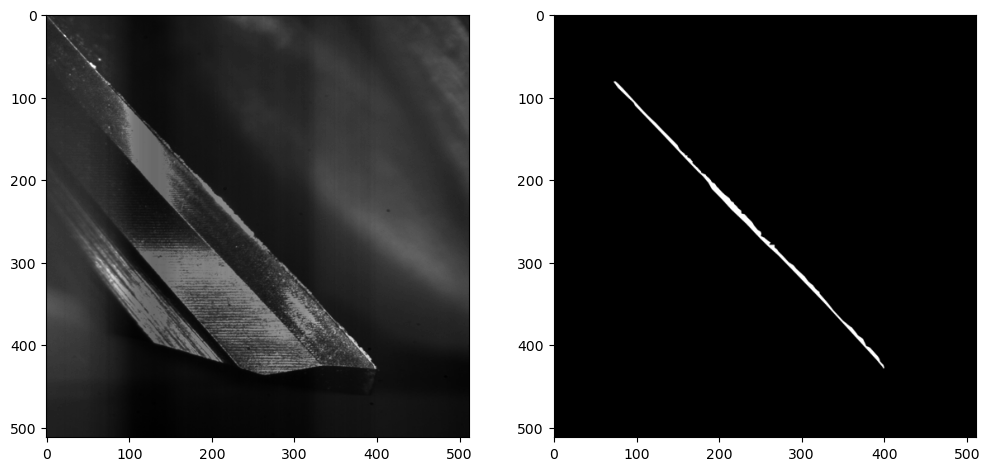

In [22]:
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

# 2.3. Model Training

Extracts image dimensions from the dataset and creates the model with those dimensions. The model is trained using X_train and y_train for the given epochs, with validation on X_test and y_test. After training, the model is saved to a file for future use.

In [23]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [24]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [25]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [27]:
#If starting with pre-trained weights. 
#model.load_weights('---.hdf5')
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save(os.path.join(current_dir, 'Model/TEST.hdf5'))

Epoch 1/5
6/6 [==============================] - 55s 10s/step - loss: 0.1549 - accuracy: 0.9572 - val_loss: 0.1345 - val_accuracy: 0.9602
Epoch 2/5
6/6 [==============================] - 67s 11s/step - loss: 0.1313 - accuracy: 0.9572 - val_loss: 0.1468 - val_accuracy: 0.9602
Epoch 3/5
6/6 [==============================] - 67s 11s/step - loss: 0.1075 - accuracy: 0.9572 - val_loss: 0.1521 - val_accuracy: 0.9602
Epoch 4/5
6/6 [==============================] - 62s 10s/step - loss: 0.0904 - accuracy: 0.9572 - val_loss: 0.1927 - val_accuracy: 0.9602
Epoch 5/5
6/6 [==============================] - 43s 7s/step - loss: 0.0816 - accuracy: 0.9572 - val_loss: 0.2852 - val_accuracy: 0.9602


# 3. Evolution

Now, let's delve into the process of extracting accuracy parameters from our model. This section involves two main components:


* Extracting Accuracy and Loss Diagrams with Epochs:
    * One fundamental aspect of assessing a model's performance is tracking its accuracy and loss over epochs. By visualizing these metrics over the course of training, we gain insights into how well our model is learning and whether it's overfitting or underfitting. We'll extract these diagrams to analyze the trends and make informed decisions about model adjustments.

* Calculating the Intersection over Union (IOU) Level:
    * Another critical metric for evaluating the performance of models, especially in tasks like object detection and semantic segmentation, is the Intersection over Union (IOU). This metric quantifies the overlap between predicted and ground-truth bounding boxes or segmentation masks. By calculating the IOU level, we can gauge how accurately our model is delineating objects or regions of interest within the data.

1/1 [==============================] - 1s 669ms/step - loss: 0.2852 - accuracy: 0.9602
Accuracy =  96.02407813072205 %


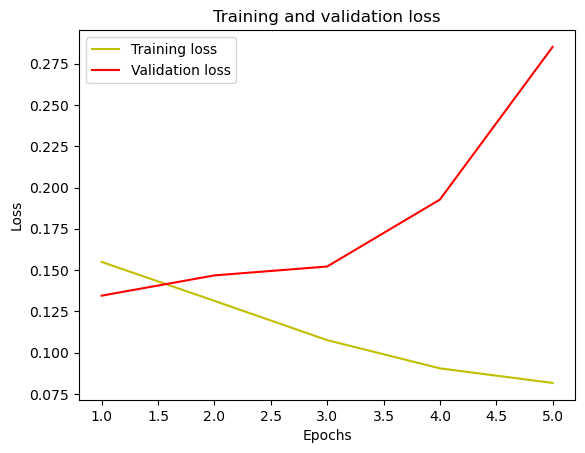

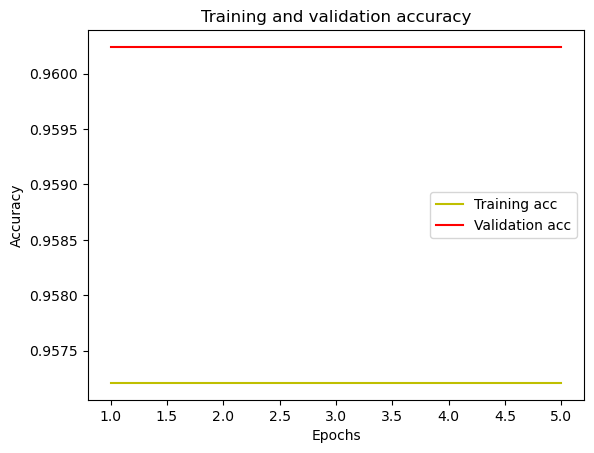

In [28]:
#Evaluate the model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.2

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 1s 651ms/step
IoU socre is:  0.025714630529981724
